In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

### Ice Cream Production Data

In [3]:
import os
df = pd.read_csv(os.path.join(os.getcwd(), 'data\ice_cream.csv'))

In [4]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [6]:
df.rename(columns={'DATE': 'date', 'IPN31152N': 'production'}, inplace=True)

In [8]:
df['date'] = pd.to_datetime(df.date)

In [10]:
# Setting the date as index
df.set_index('date', inplace=True)

In [12]:
# Obtain subset of data
start_date = pd.to_datetime('2010-01-01')
df = df[start_date:]

In [13]:
df.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


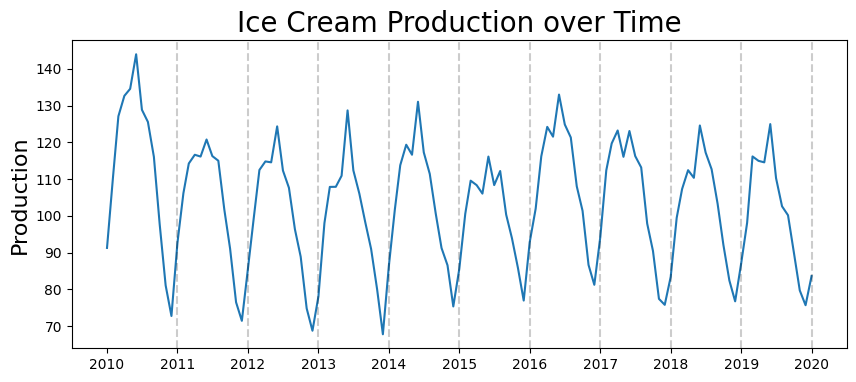

In [15]:
plt.figure(figsize=(10,4))
plt.plot(df.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
# Adding year marker
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## ACF


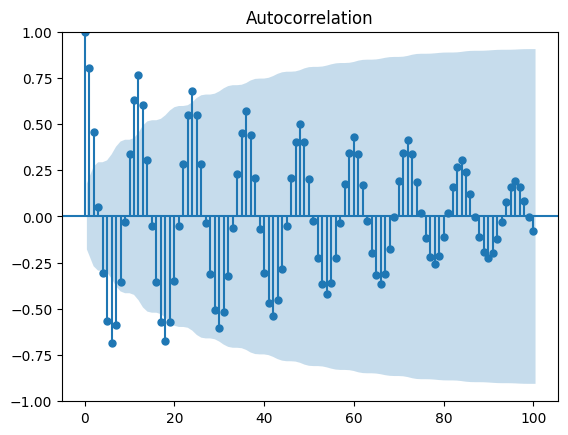

In [16]:
acf_plot = plot_acf(df.production, lags=100)

Blue cloud is the error band. Any ACF values within the band is statistically insignificant. ACF shows a gradual, exponential decay over time, this typically indicates an autoregressive (AR) process - showing diminishing autocorrelation as lag increases.

## PACF

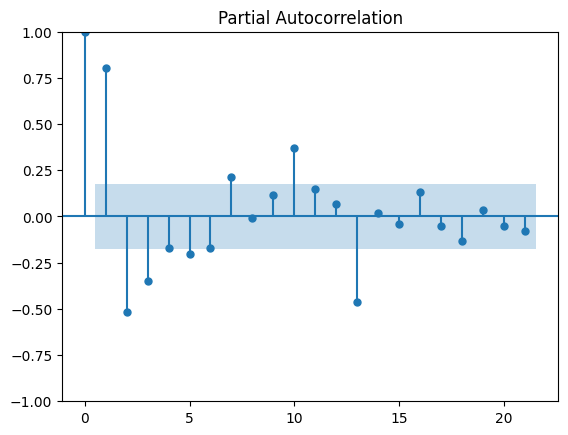

In [17]:
pacf_plot = plot_pacf(df.production)

PACF spikes at lag 1, 2, 3, 10 , 13 indicate that the observations at these lags have significant partial correlations with the current value, after accounting for the effects of intermediate lags. Spikes at non-consecutive lags, may be an indication that the time series has more complex, periodic, or seasonal patterns, which might require a higher-order AR model or a Seasonal ARIMA model.

### On stock data

In [19]:
import yfinance as yf

In [49]:
tickerSymbol = 'PLTR'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2021-1-1', end='2024-1-1')
tickerDf = tickerDf[['Close']]

In [50]:
tickerDf.head()

,Close
Date,
2021-01-04 00:00:00-05:00,23.370001
2021-01-05 00:00:00-05:00,24.600000
2021-01-06 00:00:00-05:00,23.540001
2021-01-07 00:00:00-05:00,25.000000
2021-01-08 00:00:00-05:00,25.200001


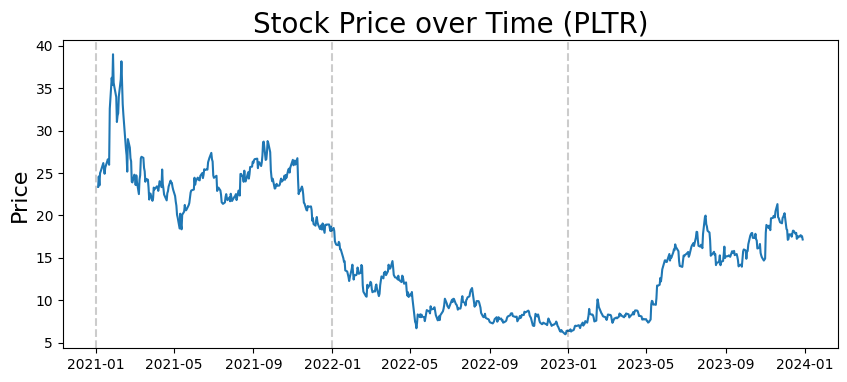

In [52]:
plt.figure(figsize=(10,4))
plt.plot(tickerDf.Close)
plt.title('Stock Price over Time (%s)'%tickerSymbol, fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(2021,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Stationarity: take first difference of this series

In [53]:
#take first difference (priceTomorrow - priceToday)
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])

In [54]:
#set first difference as variable in dataframe
tickerDf['FirstDifference'] = first_diffs

In [55]:
tickerDf.head()

,Close,FirstDifference
Date,,
2021-01-04 00:00:00-05:00,23.370001,1.230000
2021-01-05 00:00:00-05:00,24.600000,-1.059999
2021-01-06 00:00:00-05:00,23.540001,1.459999
2021-01-07 00:00:00-05:00,25.000000,0.200001
2021-01-08 00:00:00-05:00,25.200001,0.730000


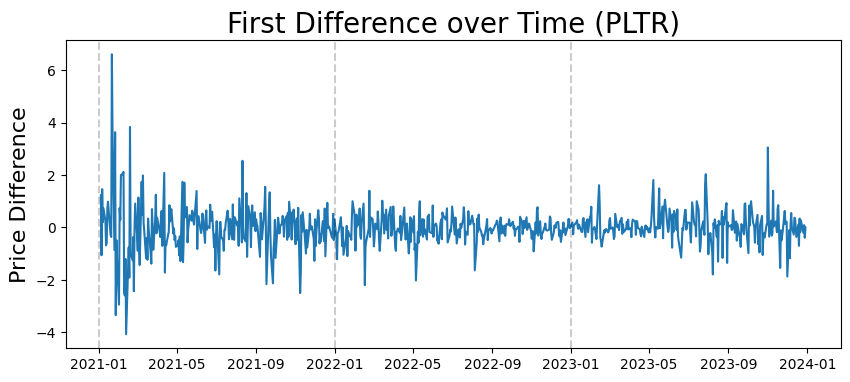

In [59]:
plt.figure(figsize=(10,4))
plt.plot(tickerDf.FirstDifference)
plt.title('First Difference over Time (%s)'%tickerSymbol, fontsize=20)
plt.ylabel('Price Difference', fontsize=16)
for year in range(2021,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## ACF

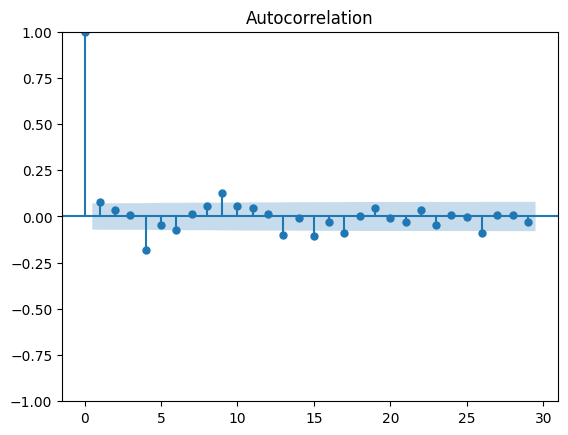

In [60]:
acf_plot = plot_acf(tickerDf.FirstDifference)


- If the ACF **cuts off sharply** after a specific lag (for example, after lag 1 or lag 2) and is close to zero for subsequent lags, this typically indicates a **moving average (MA)** process.
- For an **MA(q)** process, the ACF cuts off sharply after lag q, meaning that beyond this point, there is no autocorrelation.

## PACF

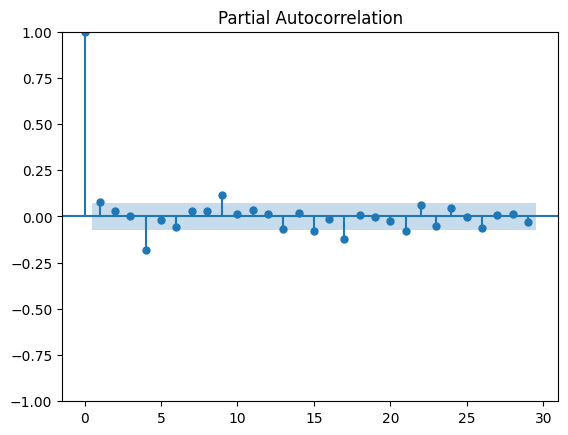

In [61]:
pacf_plot = plot_pacf(tickerDf.FirstDifference)

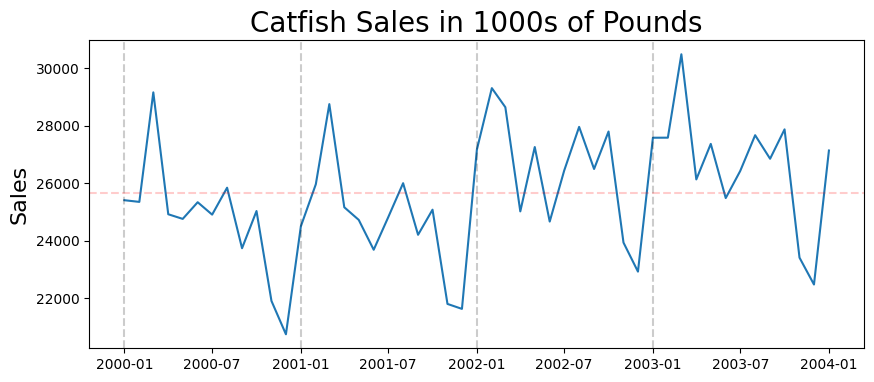

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time


catfish_sales = pd.read_csv(os.path.join(os.getcwd(), 'data/catfish.csv'), 
                             parse_dates=[0], index_col=0) # parse_dates = [0] indicates that we are treating the first column of our data as date. index_col = 0 means we are indexing our data using the first col

# Convert the index to datetime format if needed
catfish_sales.index = pd.to_datetime(catfish_sales.index)
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))


start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1) #yyyy-dd-mm
lim_catfish_sales = catfish_sales[start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.astype(float).mean().item(), color='r', alpha=0.2, linestyle='--') # converts lim_catfish_sales from object to float, convert calculated mean series to scalar using .item()


In [2]:
# Fit the ARIMA(AR, I, MA) model
model = ARIMA(lim_catfish_sales, order=(4, 1, 1)) # order=(no. of lags, no of differencing(stationality), MA: uses one lag of the forecast errors)
model_fit = model.fit()

#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   49
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -436.584
Date:                Thu, 17 Oct 2024   AIC                            885.168
Time:                        03:04:48   BIC                            896.395
Sample:                    01-01-2000   HQIC                           889.411
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6875      0.283     -2.428      0.015      -1.242      -0.133
ar.L2         -0.0543      0.096     -0.566      0.572      -0.242       0.134
ar.L3         -0.2607      0.131     -1.996      0.0

2004-02-01    27594.228543
2004-03-01    28681.652015
2004-04-01    26990.153837
2004-05-01    26503.558087
2004-06-01    26502.862012
2004-07-01    26627.129719
2004-08-01    27203.130727
2004-09-01    26954.355143
2004-10-01    27061.925940
2004-11-01    26812.038673
Freq: MS, Name: predicted_mean, dtype: float64


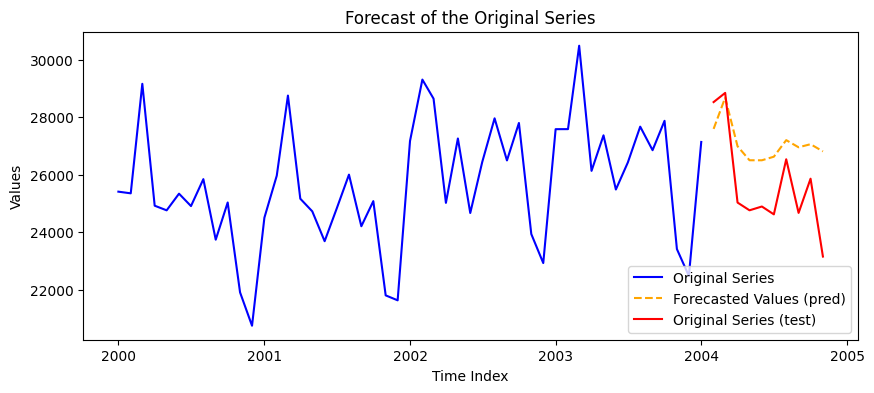

In [3]:

# Forecast the next 10 data points
future_forecast = model_fit.forecast(steps=10) #yyyy-mm-dd
print(future_forecast) # Monthly frequency
# # Convert to a pandas Series for easier handling
# future_forecast = pd.Series(future_forecast, index=pd.RangeIndex(start=len(lim_catfish_sales), stop=len(lim_catfish_sales)+10))

# Plotting the original series and the inverted forecast
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, label='Original Series', color='blue')
plt.plot(future_forecast, label='Forecasted Values (pred)', color='orange', linestyle='dashed')
plt.plot(catfish_sales[datetime(2004,2,1):datetime(2004,11,1)], label='Original Series (test)', color='red')

plt.legend()
plt.title('Forecast of the Original Series')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.show()

Root Mean Squared Error: 1865.3792161817878


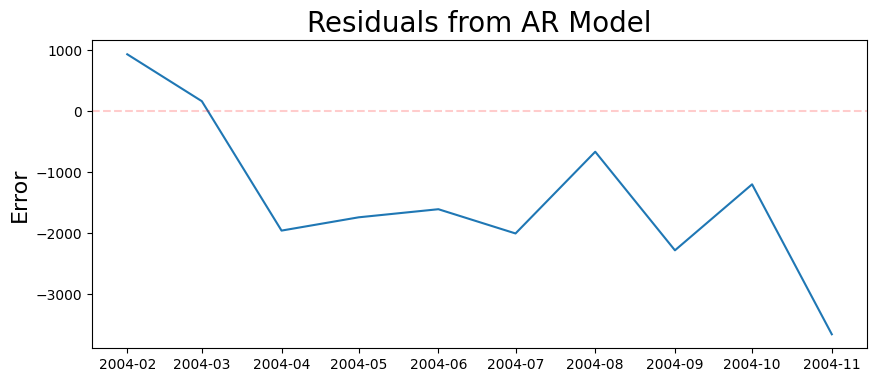

In [4]:
residuals = catfish_sales[datetime(2004,2,1):datetime(2004,11,1)].Total - future_forecast
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


In [133]:
residuals

Date
2004-02-01     931.771457
2004-03-01     163.347985
2004-04-01   -1957.153837
2004-05-01   -1739.558087
2004-06-01   -1606.862012
2004-07-01   -2004.129719
2004-08-01    -665.130727
2004-09-01   -2280.355143
2004-10-01   -1198.925940
2004-11-01   -3656.038673
Freq: MS, dtype: float64